# GATv2

After GAT, Brody et al. (2021) illustrate a confined form of attention that is computed by the graph attention network (GAT) - the ranking of the attention scores is unconditioned on the query node. This constrained form of attention is formally defined as static attention and is distinguished from a more flexible form of attention called dynamic attention. The static attention mechanism impairs the ability of GAT to accurately model the training data. To overcome this limitation, the authors propose GATv2 in 2022, a variant of dynamic graph attention that offers enhanced expressive power compared to GAT. The fixed version of the graph attention mechanism becomes

$$
\alpha_{un} = \frac{
\text{exp} \left( \vec{\textbf{a}}^\textbf{T} \text{LeakyReLu} \left(  \textbf{W} \left[ u || n \right] \right) \right)
}{
\sum_{v\in \mathcal{N}(u)} \text{exp} \left( \vec{\textbf{a}}^\textbf{T} \text{LeakyReLu} \left( \textbf{W} \left[ u || v \right] \right) \right) }
$$

which makes a significant difference in the expressiveness of the attention function - *A GATv2 layer computes dynamic attention for any set of node representations $\mathbb{K} = \mathbb{Q} = \mathcal{V}$* Brody et al. (2021) where $\mathbb{K}$ is a set of key vectors and $\mathbb{Q}$ is a set of query vectors.

In [2]:
import sys

sys.path.insert(0, '..')

In [3]:
from data.dataset import Dataset
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
import pandas as pd
import torch

In [4]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [5]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [6]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [7]:
from model.dgl.GATv2 import GATv2

AbstractModel.set_seed(2387)
num_heads = 4
k_pred_tst1 = []

for trn, val in zip(trn_sets, val_sets):
    model = GATv2(
        task_type="regression",
        # GATv2 Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[32, 32 * num_heads],
        num_heads=4,
        feat_drops=0.10594214416835764,
        attn_drops=0.014153746739612139,
        alphas=0.274140484462043,
        residuals=False,
        biases=True,
        agg_modes="flatten",
        allow_zero_in_degree=False,
        share_weights=False,
        predictor_out_feats=128,
        predictor_dropout=0,
        get_attention=False,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.04639076326774522,
        batch_size=4096,
    )
    model.fit(trn, val=val, epochs=800, min_epoch=200, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 28%|██▊       | 227/800 [00:17<00:43, 13.24it/s, loss: 0.171 rmse: 1.149]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 29%|██▊       | 229/800 [00:14<00:35, 15.87it/s, loss: 0.207 rmse: 0.958]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 31%|███       | 246/800 [00:14<00:33, 16.53it/s, loss: 0.216 rmse: 0.701]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 28%|██▊       | 224/800 [00:13<00:34, 16.53it/s, loss: 0.204 rmse: 0.915]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 30%|███       | 243/800 [00:14<00:32, 16.88it/s, loss: 0.204 rmse: 0.854]


In [8]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [9]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 0.8912272760583432
TST : R^2 0.5688286416204997


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (GATv2)\nRMSE: 0.891, $R^2$: 0.569')

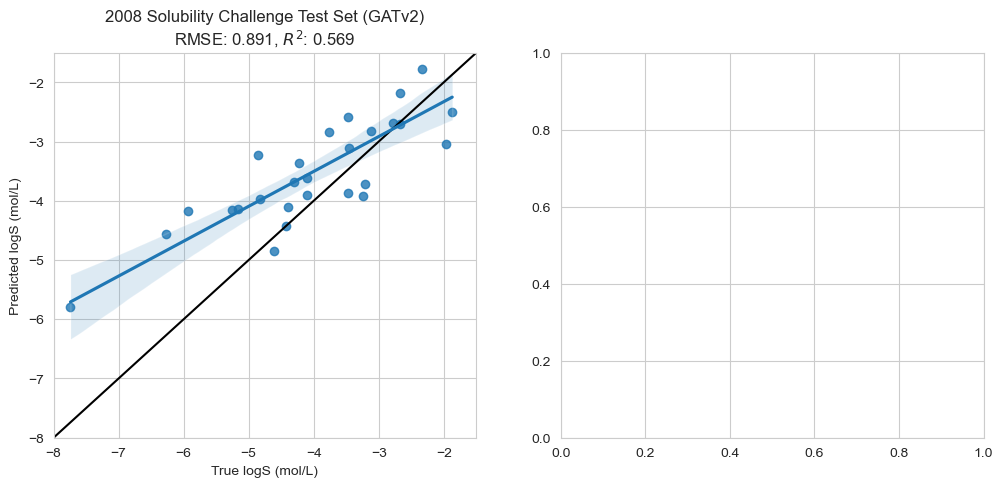

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GATv2"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")